In [1]:
from google.colab import drive
drive.mount('/content/drive')
# se define la ruta para acceder a las imágenes proporcionadas

Mounted at /content/drive


In [2]:
import torch.nn as nn
from torchsummary import summary
from time import sleep
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import glob
import torch
import torchvision
import cv2 as cv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from functools import lru_cache
import random

In [3]:
# se definen las rutas de acceso a las partes del conjunto de datos
PATH_ = r"/content/drive/MyDrive/sechs/computer_vision/proyecto"
GROUND_TRUTH = PATH_+r'/test/folder'
PATH = PATH_+r'/dataset'

torch.manual_seed(0)

# Modelo

In [4]:
# se establece la clase que define la arquitectura de la red neuronal como una subclase modulo de pytorch
class CNN(nn.Module):
    def __init__(self):
      # se incializa la clase padre
        super(CNN, self).__init__()
        # se define cada capa como un elemento secuencial, dentro de las cuales se encuentran las capas convolucionales, su función de activación y la normalización de su salida
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_5 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_6 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_7 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=313, kernel_size=1, stride=1, padding=0, bias=True)
        )
        # se define la funcioón de activación para obtener la distribución de probabilidad de los canales a y b
        self.softmax = nn.Softmax(dim=1)
        # se define la capa convolucional final que dará como resultado la salida del modelo
        self.out = nn.Conv2d(in_channels=313, out_channels=2, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.up = nn.Upsample(scale_factor=4, mode='bilinear')
  # establece el orden que el input sigue dentro de la red
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_5(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_6(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_7(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_8(x)
        logits = self.softmax(x)
        probs = self.out(logits)
        return self.up(probs), probs

In [5]:
summary(CNN(), (1,128,128), 50)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [50, 64, 128, 128]             640
              ReLU-2         [50, 64, 128, 128]               0
            Conv2d-3           [50, 64, 64, 64]          36,928
              ReLU-4           [50, 64, 64, 64]               0
       BatchNorm2d-5           [50, 64, 64, 64]             128
            Conv2d-6          [50, 128, 64, 64]          73,856
              ReLU-7          [50, 128, 64, 64]               0
            Conv2d-8          [50, 128, 32, 32]         147,584
              ReLU-9          [50, 128, 32, 32]               0
      BatchNorm2d-10          [50, 128, 32, 32]             256
           Conv2d-11          [50, 256, 32, 32]         295,168
             ReLU-12          [50, 256, 32, 32]               0
           Conv2d-13          [50, 256, 32, 32]         590,080
             ReLU-14          [50, 256,

# Training

In [6]:
from numpy.core.fromnumeric import sort
# se define el tamaño de cada  batch como 50 imagenes
batch_size = 50

# para obtener las etiquetas de cada imagen de entrenamiento se define la siguiente funcion
def get_targets():
    global images_original
    # se listan los archivos de las imagenes a color
    filenames = [img for img in glob.glob(f"{GROUND_TRUTH}/*.jpg")]
    filenames = sort(filenames)
    print(filenames)
    # se convierten los mapas de color de las imagenes a Lab para permitir el trataiemto de los mismos en el entrenamiento
    images = [cv.cvtColor(cv.imread(img), cv.COLOR_BGR2LAB) for img in filenames]
    images_original = [cv.cvtColor(cv.resize(cv.imread(img),(32,32) ), cv.COLOR_BGR2RGB) for img in filenames]
    # se cambia la dimnsion de las imagenes para satisfacer las dimensiones de los datso de entrenamiento
    images = [cv.resize(img, (32,32)) for img in images]
    # se establece como un tensor de pytorch
    images = torch.from_numpy(np.asarray([images[i:i+batch_size] for i in range(0, len(images), batch_size)]))
    images = images.float()
    # se realiza un reshape al nesor para que tenga compatibilidad con las dimensiones del conjunto de entrada
    images = torch.reshape(images, (100, 50, 3,32,32))
    images.to('cpu')
    #print(images[0][:,1:].size())
    return images
target = get_targets()

['/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image0000.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image0001.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image0002.jpg'
 ...
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image4997.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image4998.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image4999.jpg']


In [7]:
from numpy.core.fromnumeric import sort
resized_originals = []
images_original = []
batch_size = 50
# para obtener las etiquetas de cada imagen de entrenamiento se define la siguiente funcion
def get_training_images():
    global resized_originals
    # se listan los archivos de las imagenes a color
    filenames = [img for img in glob.glob(f"{PATH}/all/*.jpg")]
    filenames = sort(filenames)
    print(filenames)
    # se convierten los mapas de color de las imagenes a Lab para permitir el trataiemto de los mismos en el entrenamiento
    images = [cv.cvtColor(cv.imread(img), cv.COLOR_BGR2GRAY) for img in filenames]
    # se cambia la dimnsion de las imagenes para satisfacer las dimensiones de los datso de entrenamiento
    images = [cv.resize(img, (128,128)) for img in images]
    images_scaled = [cv.resize(img, (32,32)) for img in images]
    # se establece como un tensor de pytorch
    images = torch.from_numpy(np.asarray([images[i:i+batch_size] for i in range(0, len(images), batch_size)]))
    images = images.float()
    # se realiza un reshape al nesor para que tenga compatibilidad con las dimensiones del conjunto de entrada
    images = torch.reshape(images, (100, 50,128,128))
    images.to('cpu')
    #print(images[0][:,1:].size())
    return images
training = get_training_images()

['/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0000.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0001.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0002.jpg'
 ...
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image4997.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image4998.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image4999.jpg']


In [8]:
training, target = shuffle(training, target)

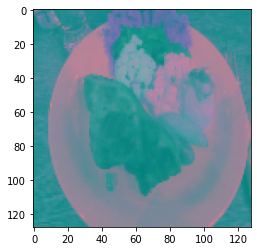

In [ ]:
plt.imshow(torch.reshape(target[0][0], (128,128,3)).int())

torch.Size([100, 50, 128, 128])

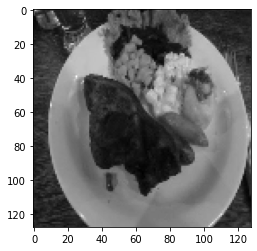

In [ ]:
plt.imshow(torch.reshape(training[0][0], (128,128)).int(), cmap='gray')
training.shape

In [13]:
# se define la función de entrenamiento recibiendo como parámetros los datos de entrenamiento (dataloader)
# la instancia del modelo, las funciones de perdida, el optimizador, las etiquetas y la cantida de epocas a entrenar
def train_(data, model, loss_a, loss_b, optimizer, target, epochs=3):
    # se define que el modelo entrará a un loop de entrenamiento
    model.train()
    # se itera por la cantida de épocas
    for epoch in range(epochs):
      data, target = shuffle(data, target)
      # se obtiene los datos de cada batch
      for batch, x in enumerate(data):
          # solo se hace uso de la imagen de entrada, ya que pytorch proporciona como etiquetas clases, no imagenes
          x = x[None, :]
          x =  torch.reshape(x, (50,1,128,128))
          x = x.to('cpu')
          # se obtiene la prediccion de la instancia del modelo
          preds, _ = model(x)
          preds = preds[:,:,:32,:32]
          #pred = torch.squeeze(pred, 1)
          # se toman los canales a y b de la imagen a color
          tgt_a, tgt_b = target[batch][:,1], target[batch][:,2]
          pred_a, pred_b = preds[:, 0], preds[:,1]
          # se calculan los errores con las funciones de perdida
          lossA = loss_a(pred_a, tgt_a)
          lossB = loss_b(pred_b, tgt_b)
          # se utiliza el backpropagation para corregir el gradiente
          optimizer.zero_grad()
          (lossA+lossB).backward()
          optimizer.step()
          print(f"batch {batch+1}  loss: {lossA} {lossB}" )
          if ((batch+1)%10==0):
            #torch.save(model.state_dict(),  f"/content/drive/MyDrive/sechs/computer_vision/proyecto/{17+epoch}_{batch}.pt")
            torch.save(model,  f"/content/drive/MyDrive/sechs/computer_vision/proyecto/saves/{40+epoch}_{batch}.pt")

In [10]:
#model = CNN().to('cpu')
model = torch.load("/content/drive/MyDrive/sechs/computer_vision/proyecto/saves/39_59.pt") 
from torch import optim
# se definen las funciones de perdida y el optimizador
loss_a = nn.CrossEntropyLoss()
loss_b = nn.CrossEntropyLoss()
# se utiliza el optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
train_(training, model, loss_a, loss_b, optimizer, target, 1)

batch 1  loss: 14462.59765625 14253.572265625
batch 2  loss: 13990.474609375 13667.431640625
batch 3  loss: 14046.5546875 14042.728515625


In [ ]:
pred = None
og = None
model.eval()
for batch, x in enumerate(training):
  x = x[None, :]
  x =  torch.reshape(x, (50,1,128,128))
  og = x
  x = x.to('cpu')
  pred, _ = model(x)
  break

torch.Size([2, 128, 128])
torch.Size([32, 32, 3])


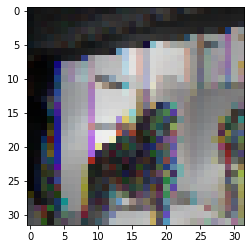

In [ ]:
id = np.random.randint(50)
pred[0,:,:32,:32]
print((pred[id].shape))
ori = resized_originals[id]
e = torch.cat((og[id], pred[id]), 0)
e = torch.reshape(e, (128,128,3)).int()
print(e[:32,:32,:].shape)
e = e[:32,:32,:].cpu().detach().numpy()
#i = pred[0]
plt.imshow(e)

(32, 32, 3)


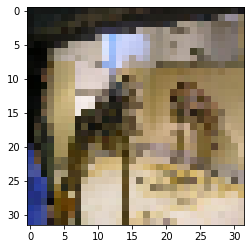

In [ ]:
print(images_original[id].shape)
plt.imshow(images_original[id],cmap='viridis')